In [25]:
import sys
sys.path.insert(0, '/home/ektov-av/python35-libs/lib/python3.5/site-packages/') 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import calendar
import time
import os
import joblib
import warnings
    
from sklearn.preprocessing import LabelEncoder, binarize

warnings.filterwarnings('ignore')

# from support_library.plot_support import *
pd.set_option('display.max_columns', None)

%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [26]:
def add_months(date, months):
    month = date.month - 1 + months
    year = date.year + month // 12
    month = month % 12 + 1
    day = min(date.day, calendar.monthrange(year, month)[1])
    return datetime.date(year, month, day)

In [27]:
def get_path(folder, file):
    return os.path.join(folder, file)

In [28]:
folder='data_csv/deal'
postfix='_mmb' #'_mmb'

## Assign FLAG to a specified value depending on the problem kind:
### -- set to 'test/train' if we want to generate a dataset with target variable  
### -- set to 'validate' if we gonna check a prediction on the validation dataset

In [29]:
FLAG='validate' # 'test/train'

## Fetching Main-Mart Database

In [30]:
df_columns_dict={}

In [133]:
if FLAG == 'test/train':
    df_kp_deal = pd.read_csv(get_path(folder, 'cvm_kp_deal_upd' + postfix + '.csv'), sep=';', 
                                                             compression='gzip', encoding='cp1251')
elif FLAG == 'validate':
    df_kp_deal = pd.read_csv(get_path(folder, 'cvm_vw_kp_deal' + '.csv'), sep=';', 
                                                             compression='gzip', encoding='cp1251')

In [ ]:
# df_kp_deal = df_kp_deal.rename(columns={'Unnamed: 0': 'IS_SOLD'})
df_kp_deal.columns = df_kp_deal.columns.map(lambda x: x.lower())
df_kp_deal.loc[:, 'date_create'] = pd.to_datetime(df_kp_deal['date_create'], format='%Y-%m-%d')
df_kp_deal.loc[:, 'date_close']  = pd.to_datetime(df_kp_deal['date_close'], format='%Y-%m-%d')
df_kp_deal.head()

In [33]:
df_kp_deal.duplicated(subset=['inn', 'id']).sum()
#df_kp_deal = df_kp_deal.drop_duplicates()

0

In [34]:
df_kp_deal.shape

(19860, 18)

In [35]:
data=df_kp_deal

In [36]:
if FLAG == 'test/train':
    ckp_filter = data[(data['year_n']==2018) & (data['month_n']>0) & (data['ckp']=='ЦА-КРЕДСМАРТ')]
    pr_gr = pd.concat([pd.DataFrame(ckp_filter.groupby(['ckp','year_n', 'month_n'])['is_sold'].count())
                      ,pd.DataFrame(ckp_filter[ckp_filter['is_sold']==1].groupby(['ckp','year_n', 'month_n'])['is_sold'].count())
                      ,pd.DataFrame(ckp_filter[ckp_filter['is_sold']==0].groupby(['ckp','year_n', 'month_n'])['is_sold'].count())
                      ,], axis=1)
    pr_gr.columns=['TOTAL', '1', '0']
    pr_gr.head(20)

In [37]:
if FLAG == 'test/train':    
    balance = pd.concat([df_kp_deal.groupby('product_group')['is_sold'].sum(), 
                         df_kp_deal.groupby('product_group')['is_sold'].count()], axis=1)
    balance.columns = ['Sum of sold', 'Count']
    balance['balance'] = balance['Sum of sold'] / balance['Count']*100
    balance = balance.sort_values('balance', ascending=False)
    balance

In [38]:
if FLAG == 'test/train':
    df_temp = df_kp_deal[['date_create', 'is_sold']]
    df_temp = df_temp.set_index('date_create')
    df_temp.groupby(pd.Grouper(freq='M'))['is_sold'].count().sort_index().plot(kind='bar', color='orange', figsize=(10,8))

In [39]:
df_columns_dict['df_kp_deal']=df_kp_deal.columns.tolist()

## Working with Client Managers' database. Historic Data over CM

In [40]:
df_kp_km = pd.read_csv(get_path(folder, 'cvm_kp_km_upd' + postfix + '.csv'), sep=';', 
                                                         compression='gzip', encoding='cp1251')

In [ ]:
# df_kp_km = df_kp_km.rename(columns={'Unnamed: 0': 'MONTH_'})
df_kp_km.columns = df_kp_km.columns.map(lambda x: x.lower())
df_kp_km.loc[:, 'month_'] = pd.to_datetime(df_kp_km['month_'], format='%Y-%m-%d')
df_kp_km = df_kp_km.drop(['year_n', 'month_n'], axis = 1)
df_kp_km.head()

In [ ]:
df_kp_km.sort_values('month_').groupby(['month_']).sum()

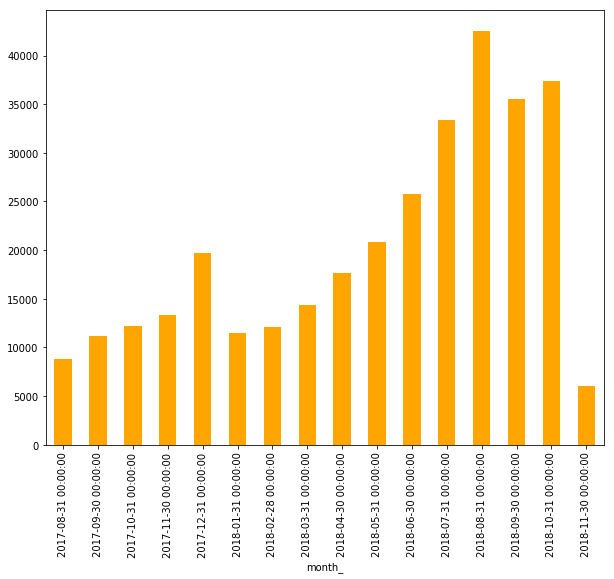

In [43]:
df_temp = df_kp_km[['month_', 'sum_sold']]
df_temp = df_temp.set_index('month_')
df_temp.groupby(pd.Grouper(freq='M'))['sum_sold'].sum().sort_index().plot(kind='bar', color='orange', figsize=(10,8))

In [44]:
df_kp_km.isnull().sum()

month_                         0
vko_id                       160
product                        0
product_group                  0
sum_sold                       0
sum_sold_cumulate              0
sum_refused                    0
sum_refused_cumulate           0
sum_sold_total               160
sum_sold_total_cumulate      160
sum_refused_total            160
sum_refused_tota_cumulate    160
dtype: int64

In [45]:
df_kp_km.shape

(1170704, 12)

In [46]:
df_kp_km = df_kp_km[~df_kp_km['vko_id'].isnull()]

In [47]:
df_kp_km=df_kp_km.drop_duplicates()

In [48]:
df_kp_km.shape

(1170544, 12)

In [49]:
df_columns_dict['df_kp_deal']=df_kp_deal.columns.tolist()

## Treatment of Historic Data over Companies

In [50]:
df_kp_company = pd.read_csv(get_path(folder, 'cvm_kp_company_upd' + postfix + '.csv'), sep=';', 
                                                         compression='gzip', encoding='cp1251')

In [51]:
df_kp_company.shape

(6135408, 14)

In [ ]:
# df_kp_company=df_kp_company.rename(columns={'Unnamed: 0': 'MONTH_'})
df_kp_company.columns = df_kp_company.columns.map(lambda x: x.lower())
df_kp_company = df_kp_company.drop(['year_n', 'month_n'], axis = 1)
df_kp_company.loc[:, 'month_'] = pd.to_datetime(df_kp_company['month_'], format='%Y-%m-%d')
df_kp_company.head()

In [ ]:
df_kp_company.sort_values('month_').groupby(['month_']).sum()

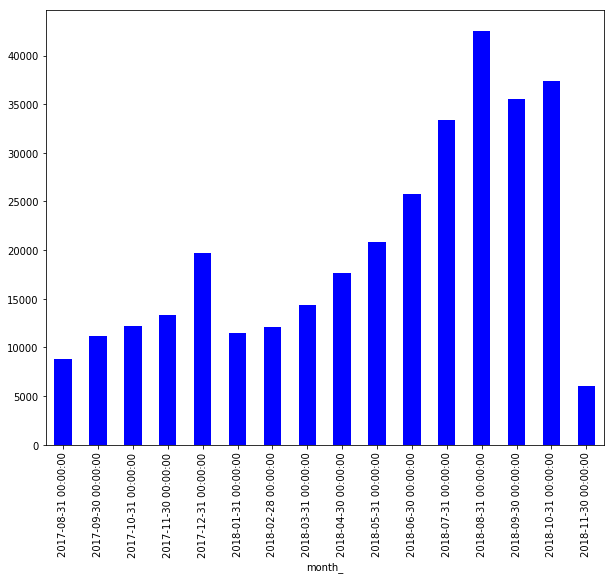

In [54]:
df_temp = df_kp_company[['month_', 'sum_sold']]
df_temp = df_temp.set_index('month_')
df_temp.groupby(pd.Grouper(freq='M'))['sum_sold'].sum().sort_index().plot(kind='bar', color='blue', figsize=(10,8))

In [55]:
df_kp_company.isnull().sum()

month_                        0
company_id                    0
product                       0
product_group                 0
sum_sold                      0
sum_sold_cumulate             0
sum_refused                   0
sum_refused_cumulate          0
sum_sold_total                0
sum_sold_total_cumulate       0
sum_refused_total             0
sum_refused_total_cumulate    0
dtype: int64

In [56]:
df_kp_company.shape

(6135408, 12)

In [57]:
df_kp_company=df_kp_company.drop_duplicates()

In [58]:
df_kp_company.shape

(6135185, 12)

In [59]:
df_kp_company.duplicated(subset=['month_', 'company_id', 'product']).sum()

49

In [60]:
df_columns_dict['df_kp_company']=df_kp_company.columns.tolist()

## Aggregates

In [ ]:
df_kp_km_aggregates = df_kp_km.groupby(['vko_id', 'month_', 'product_group']).sum().reset_index()
df_kp_km_aggregates.head()

In [62]:
df_kp_company_aggregates = df_kp_company.groupby(['company_id', 'month_', 'product_group']).sum().reset_index()

In [63]:
df_columns_dict['df_kp_km_aggregates']=df_kp_km_aggregates.columns.tolist()
df_columns_dict['df_kp_company_aggregates']=df_kp_company_aggregates.columns.tolist()

## Aggregating statistics for Products being sold by CM

In [64]:
df_kp_share_prod = pd.read_csv(get_path(folder, 'cvm_kp_km_share_prod_upd' + '.csv'), sep=';', 
                                                         compression='gzip', encoding='cp1251')

In [ ]:
# df_kp_share_prod=df_kp_share_prod.rename(columns={'Unnamed: 0': 'MONTH_'})
df_kp_share_prod.columns = df_kp_share_prod.columns.map(lambda x: x.lower())
df_kp_share_prod = df_kp_share_prod.drop(['year_n', 'month_n'], axis = 1)
df_kp_share_prod.loc[:, 'month_'] = pd.to_datetime(df_kp_share_prod['month_'], format='%Y-%m-%d')
df_kp_share_prod.head()

In [ ]:
df_kp_share_prod.groupby(['month_']).sum()

In [ ]:
df_kp_share_prod.groupby(['month_', 'vko_id']).sum().groupby(['month_']).sum()

In [68]:
df_kp_share_prod.sort_values('month_').groupby('month_')['vko_id'].count()

month_
2017-08-01    8311
2017-09-01    8321
2017-10-01    8456
2017-11-01    8553
2017-12-01    8508
2018-01-01    8606
2018-02-01    8559
2018-03-01    8594
2018-04-01    8495
2018-05-01    8397
2018-06-01    8371
2018-07-01    8422
2018-08-01    8567
2018-09-01    8261
2018-10-01    8355
Name: vko_id, dtype: int64

In [69]:
df_kp_share_prod.duplicated(subset=['month_', 'vko_id']).sum()

0

In [70]:
df_kp_share_prod.shape

(126791, 43)

In [ ]:
df_kp_share_prod.isnull().sum()

In [72]:
for col in df_kp_share_prod.columns:
    if df_kp_share_prod[col].isnull().sum() == df_kp_share_prod.shape[0]:
        df_kp_share_prod.drop([col], axis = 1, inplace=True)
        print(col+' has been deleted')

obsluzh_beneficiar has been deleted
priem_platezh has been deleted


In [73]:
df_kp_share_prod = df_kp_share_prod[~df_kp_share_prod['total_client_cnt'].isnull()]

In [74]:
df_kp_share_prod.shape

(126776, 41)

In [75]:
for col in set(df_kp_share_prod.columns) - set(['month_', 'year_n', 'month_n', 'total_client_cnt', 'vko_id']):
    df_kp_share_prod[col + '_ratio'] = df_kp_share_prod[col] / df_kp_share_prod['total_client_cnt']

In [ ]:
df_kp_share_prod.head()

In [77]:
df_columns_dict['df_kp_share_prod']=df_kp_share_prod.columns.tolist()

## Difference between current deal and previous one (by Companies)

In [78]:
df_comp_dealdiff = pd.read_csv(get_path(folder, 'cvm_kp_comp_dealdiff_upd'+ postfix +'.csv'), sep=';', 
                                                         compression='gzip', encoding='cp1251')

In [79]:
# df_comp_dealdiff = df_comp_dealdiff.rename(columns={'Unnamed: 0': 'company_id'})
df_comp_dealdiff.columns = df_comp_dealdiff.columns.map(lambda x: x.lower())
df_comp_dealdiff = df_comp_dealdiff.drop(['year_n', 'month_n'], axis = 1)
df_comp_dealdiff.loc[:, 'date_create'] = pd.to_datetime(df_comp_dealdiff['date_create'], format='%Y-%m-%d')
df_comp_dealdiff.head()

,company_id,date_create,days_between,is_previous_sold
0,1-28MP1RP,2018-10-02,40,0
1,1-28MP1RP,2018-08-23,153,0
2,1-28OIKJA,2018-06-09,22,0
3,1-28OIKJA,2018-05-18,72,1
4,1-28Q7JHA,2018-06-07,80,0


In [80]:
df_comp_dealdiff.drop_duplicates(inplace=True)

In [81]:
df_comp_dealdiff.shape

(74322, 4)

In [82]:
df_columns_dict['df_comp_dealdiff']=df_comp_dealdiff.columns.tolist()

## Difference between current deal and previous one (by CM)

In [83]:
df_km_dealdiff = pd.read_csv(get_path(folder, 'cvm_kp_km_dealdiff_upd'+ postfix +'.csv'), sep=';', 
                                                         compression='gzip', encoding='cp1251')

In [84]:
# df_km_dealdiff = df_km_dealdiff.rename(columns={'Unnamed: 0': 'vko_id'})
df_km_dealdiff.columns = df_km_dealdiff.columns.map(lambda x: x.lower())
df_km_dealdiff = df_km_dealdiff.drop(['year_n', 'month_n'], axis = 1)
df_km_dealdiff.loc[:, 'date_create'] = pd.to_datetime(df_km_dealdiff['date_create'], format='%Y-%m-%d')
df_km_dealdiff.head()

,vko_id,date_create,days_between,is_previous_sold
0,1-O1RWNL0,2018-05-10,2,0
1,1-O1RWNL0,2018-05-08,15,1
2,1-O1RWNL0,2018-04-23,3,0
3,1-O1RWNL0,2018-04-20,2,1
4,1-O1RWNL0,2018-04-09,10,1


In [85]:
df_km_dealdiff.drop_duplicates(inplace=True)

In [86]:
df_km_dealdiff.shape

(142502, 4)

In [87]:
df_km_dealdiff.columns.tolist()

['vko_id', 'date_create', 'days_between', 'is_previous_sold']

In [88]:
df_columns_dict['df_km_dealdiff']=df_km_dealdiff.columns.tolist()

In [89]:
df_columns_dict.keys()
joblib.dump(df_columns_dict, get_path('pkl_store', 'df_columns_dict.pkl'))

['pkl_store/df_columns_dict.pkl']

## Joining Databases with Aggregates on Main Mart Database

In [90]:
start_shape = df_kp_deal.shape[0]

In [91]:
df = df_kp_deal

In [92]:
df.shape

(19860, 18)

In [93]:
df['kp_prev_1'] = (pd.to_datetime({'day': 1, 'month': df['date_create'].dt.month, \
            'year': df['date_create'].dt.year}) - pd.offsets.MonthOffset(1))
df['kp_prev_2'] = (pd.to_datetime({'day': 1, 'month': df['date_create'].dt.month, \
            'year': df['date_create'].dt.year}) - pd.offsets.MonthOffset(2))
df['kp_prev_3'] = (pd.to_datetime({'day': 1, 'month': df['date_create'].dt.month, \
            'year': df['date_create'].dt.year}) - pd.offsets.MonthOffset(3))

In [ ]:
df_kp_company.loc[df_kp_company.duplicated(['company_id', 'month_', 'product'], keep=False),:].sort_values(['company_id', 'month_', 'product'], ascending=True)

In [95]:
df_kp_company.drop_duplicates(['company_id', 'month_', 'product'], keep=False, inplace=True)

In [96]:
for i in [1,2,3]:
    print('Roll back by %.d month' % i)
    df = df.merge(   df_kp_km, how='left', left_on=['vko_id', 'kp_prev_%.d' % i, 'product'], \
                     right_on=['vko_id', 'month_', 'product'], suffixes=('', '_km_shift_%.d' % i))
    count_kp_km = df.merge(df_kp_km, how='inner', left_on=['vko_id', 'kp_prev_%.d' % i, 'product'], \
             right_on=['vko_id', 'month_', 'product']).shape[0]
    
    print('CM: Databases intersection is equal to %.d rows' % (count_kp_km))
    
    df = df.merge(  df_kp_company, how='left', left_on=['company_id', 'kp_prev_%.d' % i, 'product'], \
                    right_on=['company_id', 'month_', 'product'], suffixes=('', '_company_shift_%.d' % i))
    count_kp_company = df.merge(df_kp_company, how='inner', left_on=['company_id', 'kp_prev_%.d' % i, 'product'], \
             right_on=['company_id', 'month_', 'product']).shape[0]
    
    print('COMPANIES: Databases intersection is equal to %.d rows' % (count_kp_company))

Roll back by 1 month
CM: Databases intersection is equal to 16640 rows
COMPANIES: Databases intersection is equal to 1535 rows
Roll back by 2 month
CM: Databases intersection is equal to 16616 rows
COMPANIES: Databases intersection is equal to 1529 rows
Roll back by 3 month
CM: Databases intersection is equal to 16593 rows
COMPANIES: Databases intersection is equal to 1525 rows


In [ ]:
df.head()
#df[df['sum_sold'].isnull()].head()

In [98]:
start_shape - df.shape[0]

0

In [99]:
len(set(df['company_id']) - set(df_kp_deal['company_id']))

0

## Joining Databases with aggregates

In [100]:
df_kp_company_aggregates.loc[df_kp_company_aggregates.duplicated(['company_id', 'month_', 'product_group'], keep=False),:].sort_values(['company_id', 'month_', 'product_group'], ascending=True)

,company_id,month_,product_group,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_total_cumulate


In [101]:
for i in [1, 2, 3]:
    print('Roll back by %.d month' % i)
    df = df.merge(df_kp_km_aggregates, how='left', left_on=['vko_id', 'kp_prev_%.d' % i, 'product_group'], \
             right_on=['vko_id', 'month_', 'product_group'], suffixes=('', '_agg_km_shift_%.d' % i))
    count_kp_km = df.merge(df_kp_km_aggregates, how='inner', 
                             left_on =['vko_id', 'kp_prev_%.d' % i, 'product_group'], \
                             right_on=['vko_id', 'month_', 'product_group']).shape[0]
    print('CM: Databases intersection is equal to %.d rows' % (count_kp_km))
    
    df = df.merge(df_kp_company_aggregates, how='left', left_on=['company_id', 'kp_prev_%.d' % i, 'product_group'], \
             right_on=['company_id', 'month_', 'product_group'], suffixes=('', '_agg_company_shift_%.d' % i))
    count_kp_company = df.merge(df_kp_company_aggregates, how='inner', 
                                left_on=['company_id', 'kp_prev_%.d' % i, 'product_group'], \
                                right_on=['company_id', 'month_', 'product_group']).shape[0]
    print('COMPANY: Databases intersection is equal to %.d rows' % (count_kp_company))

Roll back by 1 month
CM: Databases intersection is equal to 18736 rows
COMPANY: Databases intersection is equal to 2569 rows
Roll back by 2 month
CM: Databases intersection is equal to 18710 rows
COMPANY: Databases intersection is equal to 2562 rows
Roll back by 3 month
CM: Databases intersection is equal to 18684 rows
COMPANY: Databases intersection is equal to 2558 rows


In [102]:
start_shape - df.shape[0]

0

In [103]:
df_kp_company_aggregates['month_'].sort_values().unique()

array(['2017-08-01T00:00:00.000000000', '2017-09-01T00:00:00.000000000',
       '2017-10-01T00:00:00.000000000', '2017-11-01T00:00:00.000000000',
       '2017-12-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2018-02-01T00:00:00.000000000', '2018-03-01T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2018-05-01T00:00:00.000000000',
       '2018-06-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-08-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

## Joining df_kp_share_prod Database

In [104]:
df_kp_share_prod.shape

(126776, 79)

In [105]:
df_kp_share_prod.duplicated().sum()

0

In [ ]:
df_kp_share_prod.head()

In [107]:
for i in [1, 2, 3]:
    print('Roll back by %.d month' % i)
    df = df.merge(df_kp_share_prod, how='left', left_on=['vko_id', 'kp_prev_%.d' % i], \
             right_on=['vko_id', 'month_'], suffixes=('', '_share_prod_shift_%.d' % i))
    count = df.merge(df_kp_share_prod, how='inner', left_on=['vko_id', 'kp_prev_%.d' % i], \
             right_on=['vko_id', 'month_'], suffixes=('', '_share_prod_shift_%.d' % i)).shape[0]
    print('df_kp_share_prod: Databases intersection is equal to %.d rows' % (count_kp_km))

Roll back by 1 month
df_kp_share_prod: Databases intersection is equal to 18684 rows
Roll back by 2 month
df_kp_share_prod: Databases intersection is equal to 18684 rows
Roll back by 3 month
df_kp_share_prod: Databases intersection is equal to 18684 rows


In [108]:
start_shape - df.shape[0]

0

## Joining cvm_kp_comp_dealdiff_mmb

In [109]:
df_comp_dealdiff.duplicated(['company_id', 'date_create']).sum()

0

In [110]:
len(set(df_comp_dealdiff['company_id']) - set(df['company_id']))

41501

In [111]:
df = df.merge(df_comp_dealdiff, how='left', on =['company_id', 'date_create'], suffixes=('', '_comp_dealdiff'))

In [112]:
start_shape - df.shape[0]

0

## Joining cvm_kp_km_dealdiff_mmb

In [113]:
df = df.merge(df_km_dealdiff, how='left', on=['vko_id', 'date_create'], suffixes=('', '_km_dealdiff'))

In [87]:
#df.shape[0] - df.merge(df_km_dealdiff, how='inner', on=['vko_id', 'date_create']).shape[0]

In [114]:
start_shape - df.shape[0]

0

In [115]:
df.shape

(19860, 373)

## Cleaning dataset

In [116]:
coltypes=df.dtypes.to_dict()

In [117]:
coltypes

{'acquiring_mobile': dtype('float64'),
 'acquiring_mobile_ratio': dtype('float64'),
 'acquiring_mobile_ratio_share_prod_shift_2': dtype('float64'),
 'acquiring_mobile_ratio_share_prod_shift_3': dtype('float64'),
 'acquiring_mobile_share_prod_shift_2': dtype('float64'),
 'acquiring_mobile_share_prod_shift_3': dtype('float64'),
 'acquiring_torg': dtype('float64'),
 'acquiring_torg_ratio': dtype('float64'),
 'acquiring_torg_ratio_share_prod_shift_2': dtype('float64'),
 'acquiring_torg_ratio_share_prod_shift_3': dtype('float64'),
 'acquiring_torg_share_prod_shift_2': dtype('float64'),
 'acquiring_torg_share_prod_shift_3': dtype('float64'),
 'acreditiv': dtype('float64'),
 'acreditiv_ratio': dtype('float64'),
 'acreditiv_ratio_share_prod_shift_2': dtype('float64'),
 'acreditiv_ratio_share_prod_shift_3': dtype('float64'),
 'acreditiv_share_prod_shift_2': dtype('float64'),
 'acreditiv_share_prod_shift_3': dtype('float64'),
 'arenda_seyf': dtype('float64'),
 'arenda_seyf_ratio': dtype('float64

In [118]:
df=df.T.drop_duplicates().T

In [119]:
for col in df.columns:
    if col in list(coltypes.keys()):
        df[col]=df[col].astype(coltypes[col], copy=False)

In [120]:
df.sort_values('date_create', ascending=True, inplace=True)

In [121]:
import re
colsdel = (c for c in df.columns if re.search('(product_group_|month__)[km_shift_\d+|company_shift_\d+]', c.lower()))
colsdel=list(colsdel)
colsdel

['product_group_km_shift_1',
 'month__company_shift_1',
 'product_group_company_shift_1',
 'month__km_shift_2',
 'product_group_km_shift_2',
 'month__company_shift_2',
 'product_group_company_shift_2',
 'month__km_shift_3',
 'product_group_km_shift_3',
 'month__company_shift_3',
 'product_group_company_shift_3',
 'month__agg_km_shift_1',
 'month__agg_company_shift_1',
 'month__agg_km_shift_2',
 'month__agg_company_shift_2',
 'month__agg_km_shift_3',
 'month__agg_company_shift_3',
 'month__share_prod_shift_1',
 'month__share_prod_shift_2',
 'month__share_prod_shift_3']

In [122]:
cols_for_drop = ['id', 'vko_id', 'company_id', 'inn', 'ckp_id', 'year_n', 'month_n', 
                 'date_create', 'date_close',
                 'kp_prev_1', 'kp_prev_2','kp_prev_3', 'month_','ckp', 'type_object']
cols_for_drop.extend(colsdel)
cols_for_drop

['id',
 'vko_id',
 'company_id',
 'inn',
 'ckp_id',
 'year_n',
 'month_n',
 'date_create',
 'date_close',
 'kp_prev_1',
 'kp_prev_2',
 'kp_prev_3',
 'month_',
 'ckp',
 'type_object',
 'product_group_km_shift_1',
 'month__company_shift_1',
 'product_group_company_shift_1',
 'month__km_shift_2',
 'product_group_km_shift_2',
 'month__company_shift_2',
 'product_group_company_shift_2',
 'month__km_shift_3',
 'product_group_km_shift_3',
 'month__company_shift_3',
 'product_group_company_shift_3',
 'month__agg_km_shift_1',
 'month__agg_company_shift_1',
 'month__agg_km_shift_2',
 'month__agg_company_shift_2',
 'month__agg_km_shift_3',
 'month__agg_company_shift_3',
 'month__share_prod_shift_1',
 'month__share_prod_shift_2',
 'month__share_prod_shift_3']

list(set(df['product_group']) - set(df['product_group_km_shift_3']))

df['is_previous_sold'].isnull().sum()-df['is_previous_sold_km_dealdiff'].isnull().sum()

d=abs(df['is_previous_sold']-df['is_previous_sold_km_dealdiff'])
d=d.fillna(-1)
d[d==0].count()

d=abs(df['days_between']-df['days_between_km_dealdiff'])
d=d.fillna(-1)
d[d>=1].count()


In [123]:
df = df.drop(cols_for_drop, axis=1, errors='ignore')

In [124]:
df.head()

,tb,gosb,product,product_group,days_cr_q_end,segment_client,priority_client,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_tota_cumulate,sum_sold_company_shift_1,sum_sold_cumulate_company_shift_1,sum_refused_company_shift_1,sum_refused_cumulate_company_shift_1,sum_sold_total_company_shift_1,sum_sold_total_cumulate_company_shift_1,sum_refused_total_company_shift_1,sum_refused_total_cumulate,sum_sold_km_shift_2,sum_sold_cumulate_km_shift_2,sum_refused_km_shift_2,sum_refused_cumulate_km_shift_2,sum_sold_total_km_shift_2,sum_sold_total_cumulate_km_shift_2,sum_refused_total_km_shift_2,sum_refused_tota_cumulate_km_shift_2,sum_sold_company_shift_2,sum_sold_cumulate_company_shift_2,sum_refused_company_shift_2,sum_refused_cumulate_company_shift_2,sum_sold_total_company_shift_2,sum_sold_total_cumulate_company_shift_2,sum_refused_total_company_shift_2,sum_refused_total_cumulate_company_shift_2,sum_sold_km_shift_3,sum_sold_cumulate_km_shift_3,sum_refused_km_shift_3,sum_refused_cumulate_km_shift_3,sum_sold_total_km_shift_3,sum_sold_total_cumulate_km_shift_3,sum_refused_total_km_shift_3,sum_refused_tota_cumulate_km_shift_3,sum_sold_company_shift_3,sum_sold_cumulate_company_shift_3,sum_refused_company_shift_3,sum_refused_cumulate_company_shift_3,sum_sold_total_company_shift_3,sum_sold_total_cumulate_company_shift_3,sum_refused_total_company_shift_3,sum_refused_total_cumulate_company_shift_3,sum_sold_agg_km_shift_1,sum_sold_cumulate_agg_km_shift_1,sum_refused_agg_km_shift_1,sum_refused_cumulate_agg_km_shift_1,sum_sold_total_agg_km_shift_1,sum_sold_total_cumulate_agg_km_shift_1,sum_refused_total_agg_km_shift_1,sum_refused_tota_cumulate_agg_km_shift_1,sum_sold_agg_company_shift_1,sum_sold_cumulate_agg_company_shift_1,sum_refused_agg_company_shift_1,sum_refused_cumulate_agg_company_shift_1,sum_sold_total_agg_company_shift_1,sum_sold_total_cumulate_agg_company_shift_1,sum_refused_total_agg_company_shift_1,sum_refused_total_cumulate_agg_company_shift_1,sum_sold_agg_km_shift_2,sum_sold_cumulate_agg_km_shift_2,sum_refused_agg_km_shift_2,sum_refused_cumulate_agg_km_shift_2,sum_sold_total_agg_km_shift_2,sum_sold_total_cumulate_agg_km_shift_2,sum_refused_total_agg_km_shift_2,sum_refused_tota_cumulate_agg_km_shift_2,sum_sold_agg_company_shift_2,sum_sold_cumulate_agg_company_shift_2,sum_refused_agg_company_shift_2,sum_refused_cumulate_agg_company_shift_2,sum_sold_total_agg_company_shift_2,sum_sold_total_cumulate_agg_company_shift_2,sum_refused_total_agg_company_shift_2,sum_refused_total_cumulate_agg_company_shift_2,sum_sold_agg_km_shift_3,sum_sold_cumulate_agg_km_shift_3,sum_refused_agg_km_shift_3,sum_refused_cumulate_agg_km_shift_3,sum_sold_total_agg_km_shift_3,sum_sold_total_cumulate_agg_km_shift_3,sum_refused_total_agg_km_shift_3,sum_refused_tota_cumulate_agg_km_shift_3,sum_sold_agg_company_shift_3,sum_sold_cumulate_agg_company_shift_3,sum_refused_agg_company_shift_3,sum_refused_cumulate_agg_company_shift_3,sum_sold_total_agg_company_shift_3,sum_sold_total_cumulate_agg_company_shift_3,sum_refused_total_agg_company_shift_3,sum_refused_total_cumulate_agg_company_shift_3,total_client_cnt,oborot_kredit,invest_kredit,overdraft_kredit,proekt_finans,products_lizing,obsluzh_rts_rur,obsluzh_rts_val,spec_acc,deposit,veksel,deposit_sertificat,inkass,samoinkass,zarplat_projects,acquiring_torg,acquiring_mobile,acreditiv,valuta_control,garantee_kontract,garantee_gos,garantee_other,arenda_seyf,dbo,corporate_cards,cash_management,bank_straxovanie_imush,bank_straxovanie_lich,bank_straxovanie_otvet,einvoicing,factoring,konversion,ns_servis,ns_terminal,work_sreda,ns_sait,ns_garant,pfi,dcd,inkass_ratio,bank_straxovanie_imush_ratio,einvoicing_ratio,deposit_sertificat_ratio,acquiring_torg_ratio,konversion_ratio,overdraft_kredit_ratio,work_sreda_ratio,samoinkass_ratio,factoring_ratio,garantee_gos_ratio,obsluzh_rts_val_ratio,invest_kredit_ratio,corporate_cards_ratio,acreditiv_ratio,deposit_rati

In [125]:
null_compare = pd.DataFrame(df.isnull().sum(), columns=['train_null_count'])
null_compare['train_null_ratio'] = null_compare['train_null_count'] / df.shape[0] * 100
null_compare

,train_null_count,train_null_ratio
tb,1,0.005035
gosb,4,0.020141
product,0,0.000000
product_group,0,0.000000
days_cr_q_end,0,0.000000
segment_client,0,0.000000
priority_client,0,0.000000
sum_sold,3220,16.213494
sum_sold_cumulate,3220,16.213494
sum_refused,3220,16.213494


In [126]:
if FLAG == 'test/train':
    dropnull=null_compare[null_compare['train_null_ratio']>90.].index.tolist()
    joblib.dump(dropnull, get_path('pkl_store','dropnullcol_lst.pkl'))
elif FLAG == 'validate':
    dropnull=joblib.load(get_path('pkl_store','dropnullcol_lst.pkl'))

In [127]:
df = df.drop(dropnull, axis=1, errors='ignore')

In [128]:
df.shape

(19860, 268)

In [129]:
if FLAG == 'test/train':
    df.to_pickle(get_path('pkl_store', 'total_dataset_unencoded.pkl'))
elif FLAG == 'validate':
    df.to_pickle(get_path('pkl_store', 'test_dataset_unencoded.pkl'))

## Label encoding

In [136]:
from label_encoder import SoftLabelEncoder

In [137]:
label_encoders = {}
for col in df.dtypes[df.dtypes == 'O'].index:
    le = SoftLabelEncoder()
    df[col] = le.fit_transform(df[col].fillna('NaN'))
    label_encoders[col] = le

In [138]:
df.to_pickle(get_path('pkl_store', 'total_dataset_encod.pkl'))

In [139]:
joblib.dump(label_encoders, get_path('pkl_store', 'label_encoders.pkl'))

['pkl_store/label_encoders.pkl']

In [143]:
col_name='product_group'
le = joblib.load(get_path('pkl_store', 'label_encoders.pkl'))[col_name]

In [145]:
le.get_keys(), le.get_labels()

(dict_keys(['ВНЕШНИЙ МАЛЫЙ СМАРТ', 'ИНФОРМАЦИОННЫЕ УСЛУГИ', 'ФАКТОРИНГ', 'ВЕКСЕЛЯ', 'CASH MANAGEMENT', 'ПАКЕТЫ УСЛУГ', 'ИНВЕСТИЦИОННЫЕ ПРОДУКТЫ', 'БИЗНЕС-КАРТА', 'КАРТА ДАЛЬНОБОЙЩИКА', 'КОНВЕРСИОННЫЕ ОПЕРАЦИИ', 'КРЕДИТОВАНИЕ', 'ВНЕШНИЙ МИКРО СМАРТ', 'ЗАРПЛАТНЫЕ ПРОЕКТЫ', 'АРЕНДА СЕЙФОВ', 'ЭКВАЙРИНГ', 'РОЗНИЧНЫЕ ПРОДУКТЫ', 'ИНКАССАЦИЯ', 'ДЕПОЗИТНЫЕ СЕРТИФИКАТЫ', 'ВАЛЮТНЫЙ КОНТРОЛЬ', 'СТРАХОВАНИЕ', 'ДОСТАВКА ДЕНЕЖНОЙ НАЛИЧНОСТИ И ЦЕННОСТЕЙ', 'ДЕЛОВАЯ СРЕДА', 'ЭВОТОР', 'РКО', 'ТЕХНИЧЕСКИЕ ПРОДУКТЫ', 'КРЕДИТНАЯ БИЗНЕС-КАРТА', 'ПРИЕМ ПЛАТЕЖЕЙ ФИЗ. ЛИЦ', 'БАНКОВСКАЯ ГАРАНТИЯ', 'ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ', 'ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ', 'ПРЕМИАЛЬНАЯ БИЗНЕС-КАРТА', 'ДОКУМЕНТАРНЫЕ ОПЕРАЦИИ']),
 dict_values([6, 16, 29, 5, 0, 21, 14, 3, 17, 18, 20, 7, 13, 1, 31, 26, 15, 9, 4, 27, 12, 8, 30, 25, 28, 19, 23, 2, 10, 24, 22, 11]))

In [ ]:
product_group_lables = pd.DataFrame({'label': list(le.get_keys()), 'value': list(le.get_labels())})
product_group_lables = product_group_lables.set_index('value')
product_group_lables

In [159]:
product_group_lables.loc[0]['label'],  product_group_lables.iloc[0]['label']

('CASH MANAGEMENT', 'ВНЕШНИЙ МАЛЫЙ СМАРТ')

In [162]:
null_compare['train_null_ratio'].mean()

45.01372532639097